In [58]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [59]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

In [60]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [61]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SR3_Rc_orig = kat.SR3.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

In [62]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [74]:
###
###Extract the eigenmode of SRC with offsets in SR3
###

SR3Roc_offset = []
max_offset = .02 #20cm Roc change in SR3 curvature
steps = 5

### modulated q's at the face of SRMHR
SRMY_q1_x_list = []
SRMY_q1_y_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
q_BS_SRCY_x = []
q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
q_BS_ITMY_x = []
q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
q_BS_OMC_x = []
q_BS_OMC_y = []

### overlaps
overlap_SRC_to_ARM_x = []
overlap_SRC_to_ARM_y = []

overlap_OMC_to_ARM_x = []
overlap_OMC_to_ARM_y = []

overlap_OMC_to_SRC_x = []
overlap_OMC_to_SRC_y = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

for i in range(0,steps,1):
    dRc = (float(i)/steps) * max_offset
    SR3Roc_offset.append(dRc)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.undumpNodes()
    basekat1.parseCommands("maxtem "+str(2))
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SR3_Rc_new = SR3_Rc_orig + dRc
    kat1.SR3.Rcx.value = SR3_Rc_new
    kat1.SR3.Rcy.value = SR3_Rc_new

    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()
    SRCTL_q1_x = out_new_SRM_roc["SRCoutx"]
    SRCTL_q1_y = out_new_SRM_roc["SRCouty"]
    SRMY_q1_x = out_new_SRM_roc["SRMYqx"]
    SRMY_q1_y = out_new_SRM_roc["SRMYqy"]
    SRMY_q1_x_list.append(SRMY_q1_x)
    SRMY_q1_y_list.append(SRMY_q1_y)
    
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    q_BS_SRCY_x.append(srcx)
    q_BS_SRCY_y.append(srcy)
    
    #### Turn off all the cav commands except XARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')
    q_BS_ITMY_x.append(ARMx)
    q_BS_ITMY_y.append(ARMy)

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')
    q_BS_OMC_x.append(OMCx)
    q_BS_OMC_y.append(OMCy)
 
    overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    overlap_OMC_to_SRC_x.append(pykat.beam_param.overlap(OMCx,srcx))
    overlap_OMC_to_SRC_y.append(pykat.beam_param.overlap(OMCy,srcy))
    
    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = True
    #    kat1.cavXARM.enabled = True
    #    kat1.cavYARM.enabled = True
    #kat1.cavSRY.enabled = True
    
    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)
    
    
    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [64]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI
darm_list = []
freq = []

SRCTL_q3_x_list = []
SRCTL_q3_y_list = []

SRMY_q3_x_list =[]
SRMY_q3_y_list =[]


for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(darm_commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands(pds)
    basekat3.parseCommands(add_squeezing)
    basekat3.parseCommands("maxtem "+str(4))
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SR3_Rc = kat.SR3.Rc
    dRc = SR3Roc_offset[i]
    
    kat3.SR3.Rcx.value = SR3_Rc + dRc
    kat3.SR3.Rcy.value = SR3_Rc + dRc

    #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3

    out3 = kat3.run()
    SRCTL_q3_x = out3["SRCoutx"]
    SRCTL_q3_y = out3["SRCouty"]
    
    SRMY_q3_x = out3["SRMYqx"]
    SRMY_q3_y = out3["SRMYqy"]
    
    SRCTL_q3_x_list.append(SRCTL_q3_x)
    SRMY_q3_x_list.append(SRMY_q3_x)

    freq.append(out3.x)
    darm_list.append(out3['NSR_with_RP'])
    
    


Successfully Mode-Matched! >99.9% overlap
f1 is 0.39732883454347623
f2 is -0.3972052600409401
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0022131657051496782
f2 is -0.002113045405765214
Successfully Mode-Matched! >99.9% overlap
f1 is 0.00104662627843211
f2 is -0.0009465709091871427
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0006503215788604335
f2 is -0.0005502882586657894
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0004454765398544667
f2 is -0.00034545461193876434


In [65]:
#### Get overlaps in the final state

f_overlap_SRC_to_ARM_x = []
f_overlap_SRC_to_ARM_y = []

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

f_overlap_OMC_to_SRC_x = []
f_overlap_OMC_to_SRC_y = []

f1_list = []
f2_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
f_q_BS_SRCY_x = []
f_q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
f_q_BS_ITMY_x = []
f_q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
f_q_BS_OMC_x = []
f_q_BS_OMC_y = []

for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands(pds)
    basekat3.parseCommands(add_squeezing)
    basekat3.parseCommands("maxtem "+str(2))
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SR3_Rc = kat.SR3.Rc
    dRc = SR3Roc_offset[i]
    
    kat3.SR3.Rcx.value = SR3_Rc + dRc
    kat3.SR3.Rcy.value = SR3_Rc + dRc

    #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3
    
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat3,'cavSRY')
    f_q_BS_SRCY_x.append(srcx)
    f_q_BS_SRCY_y.append(srcy)


    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat3,'cavXARM')
    f_q_BS_ITMY_x.append(ARMx)
    f_q_BS_ITMY_y.append(ARMy)


    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat3,'cavOMC')
    f_q_BS_OMC_x.append(OMCx)
    f_q_BS_OMC_y.append(OMCy)

    f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    f_overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    f_overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    f_overlap_OMC_to_SRC_x.append(pykat.beam_param.overlap(OMCx,srcx))
    f_overlap_OMC_to_SRC_y.append(pykat.beam_param.overlap(OMCy,srcy))
    
    f1_list.append(f1)
    f2_list.append(f2) 

Successfully Mode-Matched! >99.9% overlap
f1 is 0.39732883454347623
f2 is -0.3972052600409401
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0022131657051496782
f2 is -0.002113045405765214
Successfully Mode-Matched! >99.9% overlap
f1 is 0.00104662627843211
f2 is -0.0009465709091871427
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0006503215788604335
f2 is -0.0005502882586657894
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0004454765398544667
f2 is -0.00034545461193876434


In [1]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.95, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(f_overlap_SRC_to_ARM_x[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

pl.loglog(freq[0], out_perfect_mm_nosqz['NSR_with_RP'],'--',linewidth=3, label='aLIGO Baseline')
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

pl.title("SRCtoOMC: QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

###Colorbar formatting
cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap SRC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=20) 
cb.update_ticks()

pl.savefig("SRCtoOMC_ht_varyingSR3_w10dbSqz.png")

pl.show()



NameError: name 'pl' is not defined

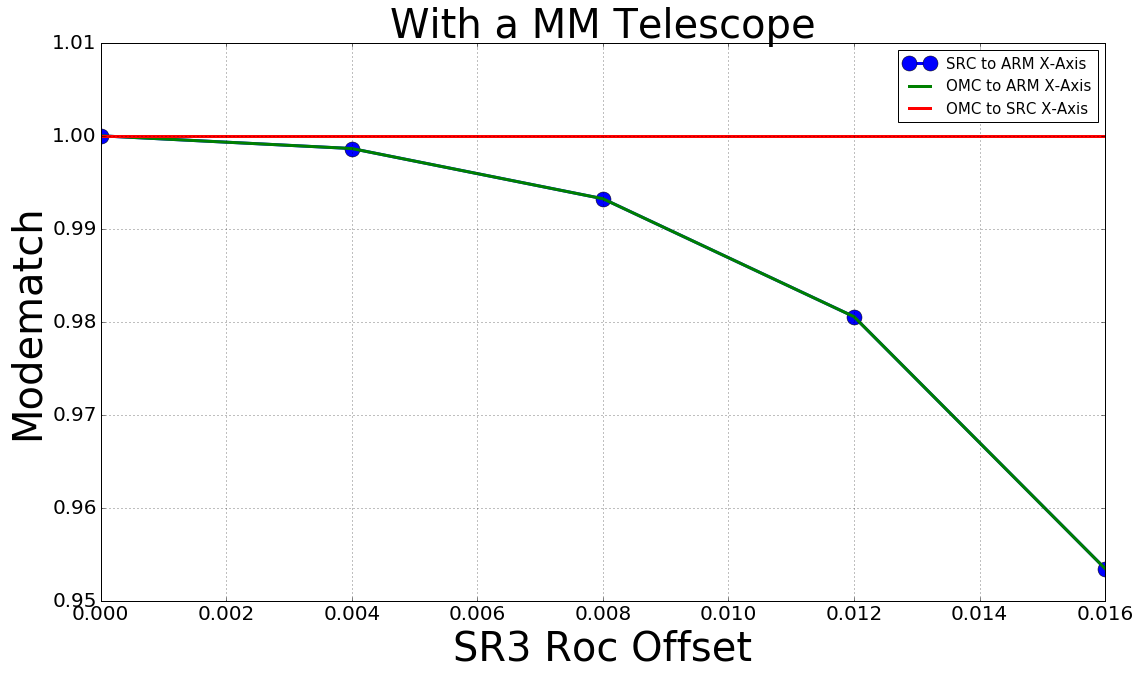

In [67]:
pl.figure(figsize=(18, 10), dpi=80)

pl.title("With a MM Telescope",fontsize=40)

pl.plot(SR3Roc_offset, f_overlap_SRC_to_ARM_x,'o-',markersize=15,linewidth=3, label='SRC to ARM X-Axis')
pl.plot(SR3Roc_offset, f_overlap_OMC_to_ARM_x,linewidth=3, label='OMC to ARM X-Axis')
pl.plot(SR3Roc_offset, f_overlap_OMC_to_SRC_x,linewidth=3, label='OMC to SRC X-Axis')


pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.ylim(.95,1.01)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

pl.xlabel("SR3 Roc Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

pl.savefig("SRCtoOMC_MMvsSR3offset_w_MMTT_10dbSqz.eps")

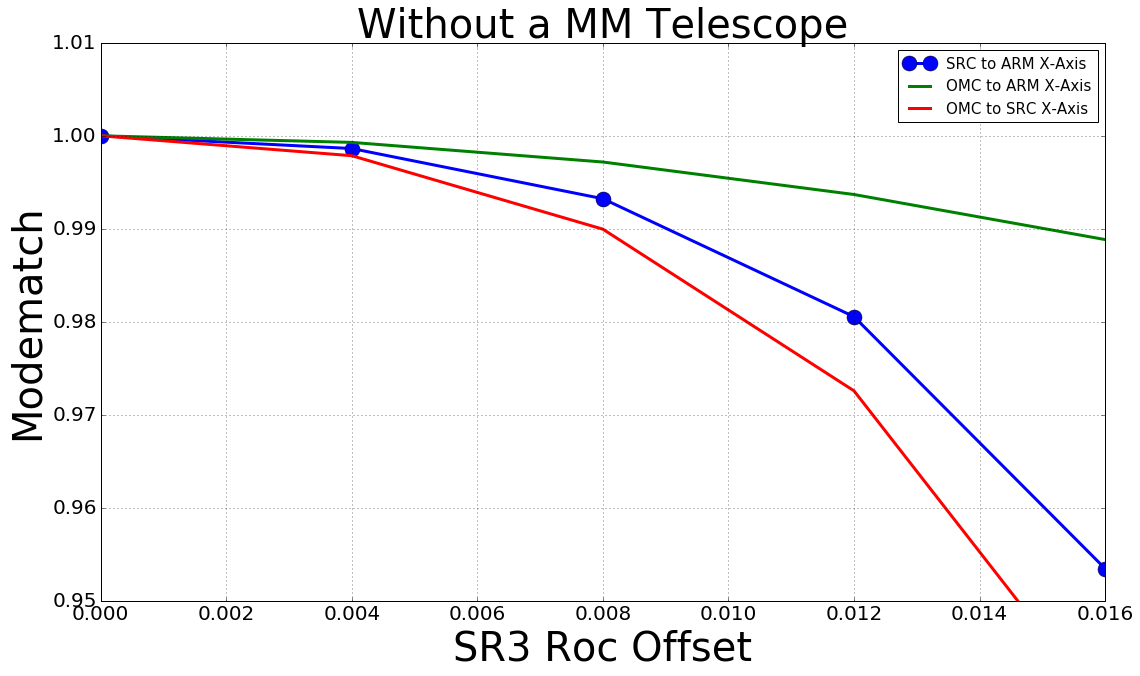

In [75]:
pl.figure(figsize=(18, 10), dpi=80)

pl.title("Without a MM Telescope",fontsize=40)

pl.plot(SR3Roc_offset, overlap_SRC_to_ARM_x,'o-',markersize=15,linewidth=3, label='SRC to ARM X-Axis')
pl.plot(SR3Roc_offset, overlap_OMC_to_ARM_x,linewidth=3, label='OMC to ARM X-Axis')
pl.plot(SR3Roc_offset, overlap_OMC_to_SRC_x,linewidth=3, label='OMC to SRC X-Axis')

pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.ylim(.95,1.01)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

pl.xlabel("SR3 Roc Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

pl.savefig("SRCtoOMC_MMvsSR3offset_wo_MMTT_10dbSqz.eps")

In [69]:
"""#Verify that the maxtem is suitable by increasing the maxtem
#to see that the cconverge.
katfile_findtem = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_findTEM.kat"

dr = SR3Roc_offset[-1]
SR3_Rc = kat.SR3.Rc


D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

kat3.lSRMTT1.L.value = d1
kat3.SRMTT1.f.value = f1_list[-1]
kat3.lSRMTT2.L.value = d2
kat3.SRMTT2.f.value = f2_list[-1]
kat3.lIBAin.L.value = d3

darm1 = []
maxtem=5
for i in range(0,maxtem,1):
    basekat4 = pykat.finesse.kat() 
    basekat4.loadKatFile(katfile_findtem)
    basekat4.parseCommands(darm_commands)
    basekat4.parseCommands("maxtem "+str(i))
    basekat4.parseCommands(add_squeezing)
    basekat4.parseCommands(cav_commands_SRX_first)
    basekat4.undumpNodes() #undump the vacuum nodes
    kat4=basekat4.deepcopy() #copy kat code
    kat4.verbose = False
    kat4.SR3.Rcx.value = SR3_Rc + dr
    kat4.SR3.Rcy.value = SR3_Rc + dr
    kat4.lSRMTT1.L.value = d1
    kat4.SRMTT1.f.value = f1_list[-1]
    kat4.lSRMTT2.L.value = d2
    kat4.SRMTT2.f.value = f2_list[-1]
    kat4.lIBAin.L.value = d3

    out4 = kat4.run()
    darm1.append(out4['NSR_with_RP'])"""

'#Verify that the maxtem is suitable by increasing the maxtem\n#to see that the cconverge.\nkatfile_findtem = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_findTEM.kat"\n\ndr = SR3Roc_offset[-1]\nSR3_Rc = kat.SR3.Rc\n\n\nD  = 0.491516 # total distance from SRC to OFI\nd1 = 0.25\nd2 = 0.0001\nd3 = D-d1-d2\n\nkat3.lSRMTT1.L.value = d1\nkat3.SRMTT1.f.value = f1_list[-1]\nkat3.lSRMTT2.L.value = d2\nkat3.SRMTT2.f.value = f2_list[-1]\nkat3.lIBAin.L.value = d3\n\ndarm1 = []\nmaxtem=5\nfor i in range(0,maxtem,1):\n    basekat4 = pykat.finesse.kat() \n    basekat4.loadKatFile(katfile_findtem)\n    basekat4.parseCommands(darm_commands)\n    basekat4.parseCommands("maxtem "+str(i))\n    basekat4.parseCommands(add_squeezing)\n    basekat4.parseCommands(cav_commands_SRX_first)\n    basekat4.undumpNodes() #undump the vacuum nodes\n    kat4=basekat4.deepcopy() #copy kat code\n    kat4.verbose = False\n    kat4.SR3.Rcx.value = SR3_Rc + dr\n    kat4.SR3.Rcy.value = SR3_Rc + dr\n    kat4.lSRMTT1.L.value = d1\n   

In [70]:
"""data6 = np.loadtxt('test_maxtem6.out',comments='%')
maxtem6_freq,maxtem6_darm= load(data6)

data8 = np.loadtxt('test_maxtem8.out',comments='%')
maxtem8_freq,maxtem8_darm= load(data8)

data10 = np.loadtxt('test_maxtem10.out',comments='%')
maxtem10_freq,maxtem10_darm= load(data10)"""

"data6 = np.loadtxt('test_maxtem6.out',comments='%')\nmaxtem6_freq,maxtem6_darm= load(data6)\n\ndata8 = np.loadtxt('test_maxtem8.out',comments='%')\nmaxtem8_freq,maxtem8_darm= load(data8)\n\ndata10 = np.loadtxt('test_maxtem10.out',comments='%')\nmaxtem10_freq,maxtem10_darm= load(data10)"

In [71]:
"""pl.figure(figsize=(18, 10), dpi=80)

for i in range(0,maxtem,2):
    pl.loglog(freq[0], np.real(darm1[i]),linewidth=3, label="maxtem "+str(i))
    pl.xlim(freq[0].min(),freq[0].max())
pl.loglog(maxtem6_freq, maxtem6_darm,label='Maxtem 6',linewidth=3)
pl.loglog(maxtem8_freq, maxtem8_darm,label='Maxtem 8',linewidth=3)
pl.loglog(maxtem10_freq, maxtem10_darm,label='Maxtem 10',linewidth=3)
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'-o',markersize=10,\
          linewidth=3,label='No SR3 Variance')


pl.title("QN-Limited Varying MaxTEM ",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.savefig("ht_findMaxTEM_SR3RocMax.eps")"""

'pl.figure(figsize=(18, 10), dpi=80)\n\nfor i in range(0,maxtem,2):\n    pl.loglog(freq[0], np.real(darm1[i]),linewidth=3, label="maxtem "+str(i))\n    pl.xlim(freq[0].min(),freq[0].max())\npl.loglog(maxtem6_freq, maxtem6_darm,label=\'Maxtem 6\',linewidth=3)\npl.loglog(maxtem8_freq, maxtem8_darm,label=\'Maxtem 8\',linewidth=3)\npl.loglog(maxtem10_freq, maxtem10_darm,label=\'Maxtem 10\',linewidth=3)\npl.loglog(out_perfect_mm.x, np.real(out_perfect_mm[\'NSR_with_RP\']),\'-o\',markersize=10,          linewidth=3,label=\'No SR3 Variance\')\n\n\npl.title("QN-Limited Varying MaxTEM ",fontsize=30)\npl.xlim(freq[0].min(),freq[0].max())\npl.xlabel("Frequency [Hz]",fontsize=30)\npl.ylabel("Strain sensitivity [$1/\\sqrt{\\mathrm{Hz}}$]",fontsize=30)\n\n###Main plot formatting\npl.tick_params(labelsize=20)\npl.grid(True, zorder=-1)\npl.legend(fontsize=15)\n\npl.savefig("ht_findMaxTEM_SR3RocMax.eps")'

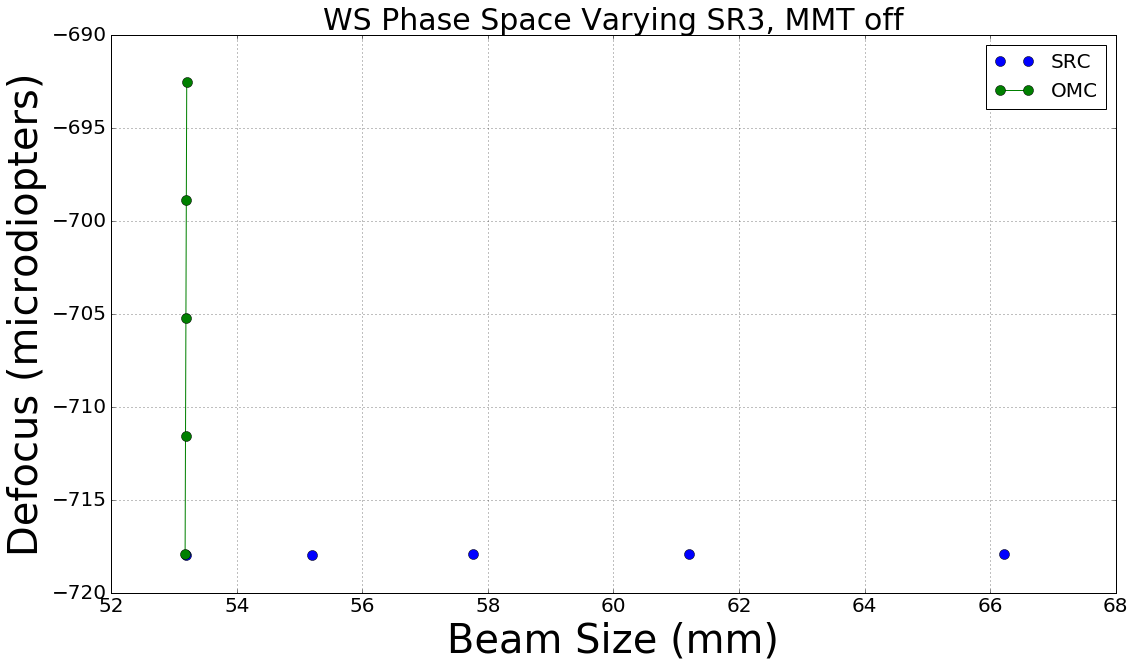

In [82]:
### beamsize is in mm and defocus is in microdipoters (no MM)
SRC_wx, SRC_wy, SRC_sx, SRC_sy = get_WS.phase_space(q_BS_SRCY_x,q_BS_SRCY_y)
OMC_wx, OMC_wy, OMC_sx, OMC_sy = get_WS.phase_space(q_BS_OMC_x,q_BS_OMC_y)

### beamsize is in mm and defocus is in microdipoters (w/ MM)
f_SRC_wx, f_SRC_wy, f_SRC_sx, f_SRC_sy = get_WS.phase_space(f_q_BS_SRCY_x,f_q_BS_SRCY_y)
f_OMC_wx, f_OMC_wy, f_OMC_sx, f_OMC_sy = get_WS.phase_space(f_q_BS_OMC_x,f_q_BS_OMC_y)

pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.title("WS Phase Space Varying SR3, MMT off",fontsize=30)
pl.plot(SRC_wx,SRC_sx,'o', markersize = 10,label='SRC')
pl.plot(OMC_wx,OMC_sx,'-o', markersize = 10,label='OMC')

pl.legend(fontsize=20)

pl.ticklabel_format(useOffset=False)
pl.xlabel("Beam Size (mm)",fontsize=40)
pl.ylabel("Defocus (microdiopters)",fontsize=40)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.grid()

pl.savefig("SRCtoOMC_WSPhaseSpaceVarySR3_OMC_SRC_wSqz_noMM.png")
pl.show()


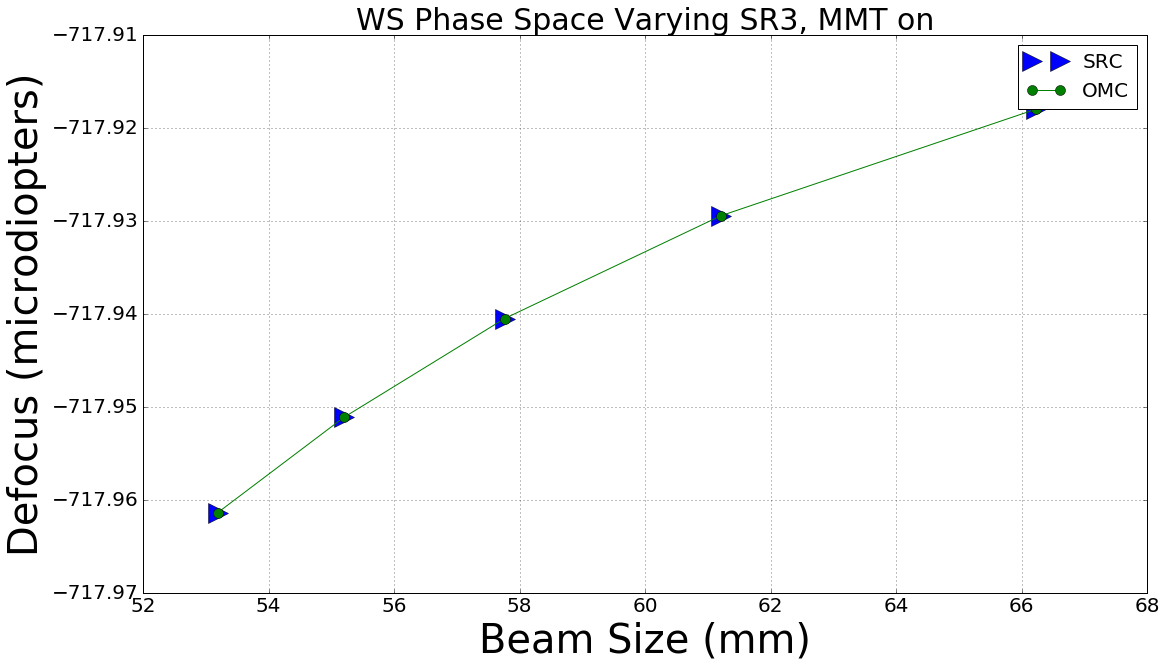

In [84]:
### beamsize is in mm and defocus is in microdipoters (w/ MM)
f_SRC_wx, f_SRC_wy, f_SRC_sx, f_SRC_sy = get_WS.phase_space(f_q_BS_SRCY_x,f_q_BS_SRCY_y)
f_OMC_wx, f_OMC_wy, f_OMC_sx, f_OMC_sy = get_WS.phase_space(f_q_BS_OMC_x,f_q_BS_OMC_y)

pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.title("WS Phase Space Varying SR3, MMT on",fontsize=30)
pl.plot(f_SRC_wx,f_SRC_sx,'>', markersize = 20,label='SRC')
pl.plot(f_OMC_wx,f_OMC_sx,'-o', markersize = 10,label='OMC')

pl.legend(fontsize=20)

pl.ticklabel_format(useOffset=False)
pl.xlabel("Beam Size (mm)",fontsize=40)
pl.ylabel("Defocus (microdiopters)",fontsize=40)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.grid()

pl.savefig("SRCtoOMC_WSPhaseSpaceVarySR3_OMC_SRC_wSqz_wMM.png")
pl.show()
